In [1]:
import sys
print(sys.path)
sys.path.append('/home/zinovyev/anaconda3/envs/geo_env/lib/python3.7/site-packages/')

['/mnt/c/MyPrograms/Python/COVID_model', '/home/zinovyev/anaconda3/envs/covid/lib/python310.zip', '/home/zinovyev/anaconda3/envs/covid/lib/python3.10', '/home/zinovyev/anaconda3/envs/covid/lib/python3.10/lib-dynload', '', '/home/zinovyev/anaconda3/envs/covid/lib/python3.10/site-packages']


In [52]:
from platform import python_version
python_version()
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import scipy
from scipy.stats.mstats import winsorize
from scipy.stats import stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
from tqdm import tqdm


from descartes import PolygonPatch
def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.85, zorder=2 ))

/tmp/ipykernel_12895/1582704073.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


List of country names: ['Fiji', 'Tanzania', 'W. Sahara', 'Canada', 'United States of America', 'Kazakhstan', 'Uzbekistan', 'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile', 'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti', 'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway', 'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste', 'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil', 'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua', 'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela', 'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico', 'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal', 'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon', 'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau', 'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.', 'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'Mozambique', 'eSwatini', 'Angola', 'Burundi', 'Israel', 'Lebanon', 'Madagascar', '

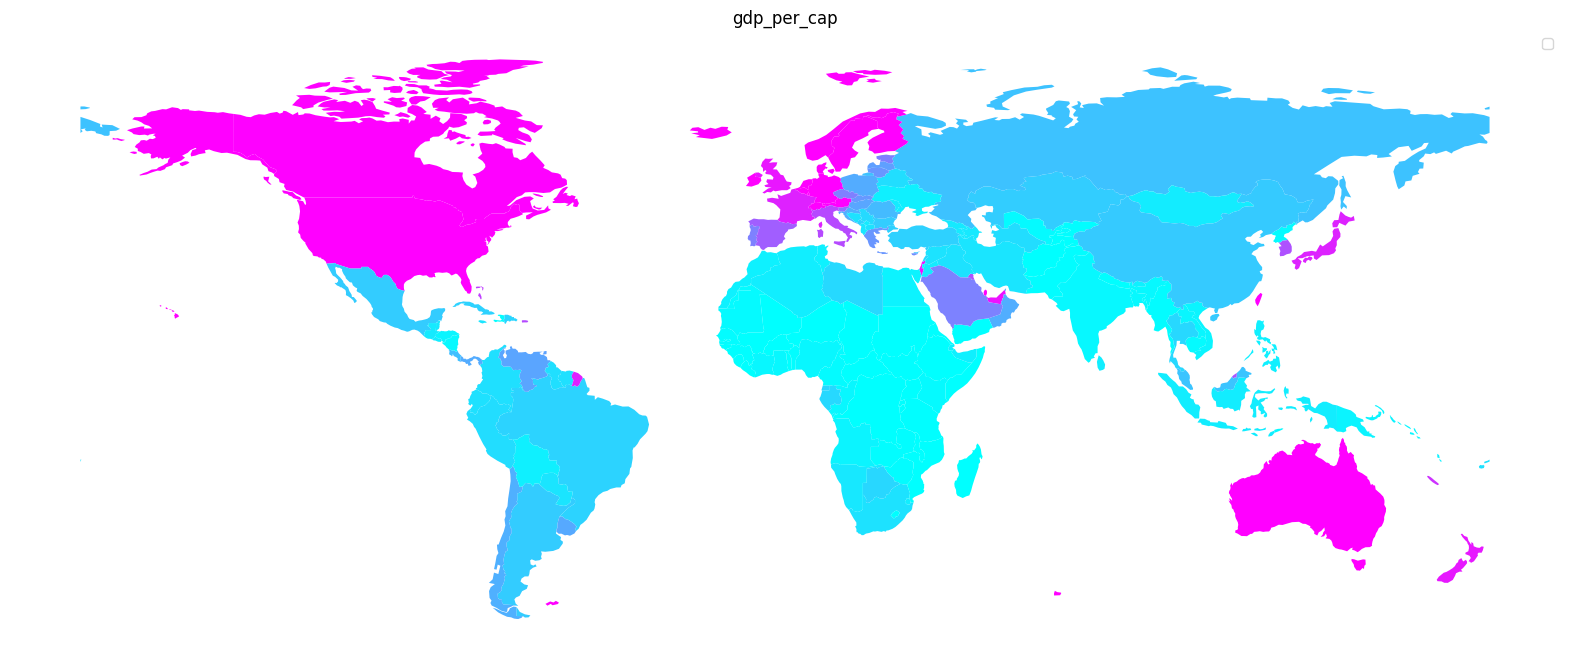

In [14]:
# Read world map

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.head()

print('List of country names:',list(world.name))

world = world[(world.pop_est>0) & (world.name!="Antarctica") & (world.name!="Greenland")]
world['gdp_per_cap'] = winsorize(world.gdp_md_est / world.pop_est * 1000000, limits=[0.1, 0.1])

world.plot(column='gdp_per_cap',figsize=(20,20),cmap='cool')
countries_gis = list(world['name'])
plt.title('gdp_per_cap')
plt.legend()
plt.axis('off')
plt.show()

In [17]:
# Loading data table and renaming some of the countries to make it consistent with geopandas
# Adding columns with logarithms of q and population 
# Filtering out countries with anomalous q value

tab = pd.read_csv('data/data.txt',sep='\t')
#display(tab)
q = tab['q'].to_numpy()
#q_thresh = 1e6
#q_thresh = 1e100
q_thresh = 50000
inds_excluded = np.where(q>q_thresh)[0]
inds = np.where(q<q_thresh)[0]
print('Outliers by q:')
display(tab.iloc[inds_excluded])
tab = tab.iloc[inds]
tab['logq'] = np.log10(tab['q'])
tab['log_population'] = np.log10(tab['Population'])

original_names = list(tab['Country'])
#print(original_names)

# Correct some names to make them compatible with geopandas
countries = list(tab['Country'])
countries[countries.index('Equatorial Guinea')] = 'Eq. Guinea'
countries[countries.index('Bosnia and Herzegovina')] = 'Bosnia and Herz.'
if 'Democratic Republic of Congo' in countries:
    countries[countries.index('Democratic Republic of Congo')] = 'Dem. Rep. Congo'
countries[countries.index('Dominican Republic')] = 'Dominican Rep.'
countries[countries.index('Central African Republic')] = 'Central African Rep.'
countries[countries.index('United States')] = 'United States of America'
countries[countries.index("Cote d'Ivoire")] = "Côte d'Ivoire"
countries[countries.index("South Sudan")] = "S. Sudan"
countries[countries.index("Eswatini")] = "eSwatini"
#countries[countries.index("Democratic Republic of Congo")] = "Dem. Rep. Congo"

tab['Country'] = countries

Outliers by q:


Region  Population  Ndays  \
21           Africa excl. North    20903278    200   
22           Africa excl. North    11890781    200   
27           Africa excl. North    16425859    200   
29       Asia excl. Middle East  1439323774    200   
39           Africa excl. North    89561404    300   
74       Asia excl. Middle East   126476458    150   
93           Africa excl. North    20250834    250   
100      Asia excl. Middle East     3278292    225   
110          Africa excl. North    24206636    250   
118      Asia excl. Middle East     8947027    200   
143      Asia excl. Middle East    21413250    200   
149      Asia excl. Middle East    23816775    300   
151      Asia excl. Middle East    69799978    250   
152      Asia excl. Middle East     1318442    300   
155  North Africa & Middle East    11818618    150   
157          Africa excl. North    45741000    150   
165      Asia excl. Middle East    97338583    150   
166  North Africa & Middle East    29825968    300   

                          Country  GDP_per_capita_PPP       a     K2  \
21                   Burkina Faso              2274.0  0.2193   7.71   
22                        Burundi               771.2  0.1472   8.73   
27                           Chad              1602.4  0.2422   5.97   
29                          China             17210.8  0.2902   2.67   
39   Democratic Republic of Congo              1141.8  0.1839   6.68   
74                          Japan             42390.4  0.2434   8.59   
93                           Mali              2348.0  0.1606   8.70   
100                      Mongolia             12366.9  0.1511   5.83   
110                         Niger              1288.3  0.1690   5.05   
118              Papua New Guinea              4286.6  0.2156   6.98   
143                     Sri Lanka             13224.6  0.1383   8.74   
149                        Taiwan             55724.0  0.2281   3.92   
151                      Thailand             18232.8  0.2149   4.07   
152                         Timor              4141.3  0.3261   2.82   
155                       Tunisia             10822.8  0.2631   6.92   
157                        Uganda              2294.3  0.1503  25.59   
165                       Vietnam              8650.1  0.1670   6.01   
166                         Yemen              3688.5  0.1512   2.62   

               q    Io       R2  
21      886930.0  1.10  0.98783  
22      802190.0  0.25  0.99332  
27      495020.0  0.14  0.99672  
29      378370.0  1.00  0.99460  
39      128920.0  0.04  0.99310  
74       94603.0  0.05  0.99223  
93       92120.0  0.95  0.99465  
100     160650.0  0.75  0.98627  
110     548050.0  3.29  0.98097  
118     381740.0  0.09  0.99689  
143      70877.0  1.55  0.99275  
149    3602440.0  0.01  0.99495  
151     555808.0  3.04  0.99312  
152    3693710.0  0.05  0.96226  
155     201180.0  1.38  0.99442  
157    2931510.0  0.15  0.98450  
165  107694890.0  0.05  0.98301  
166     232270.0  1.15  0.99858

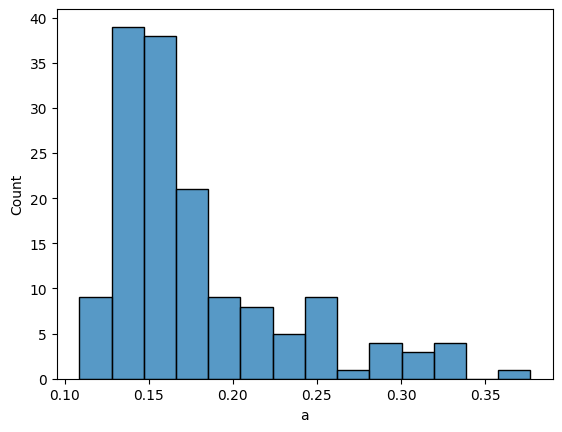

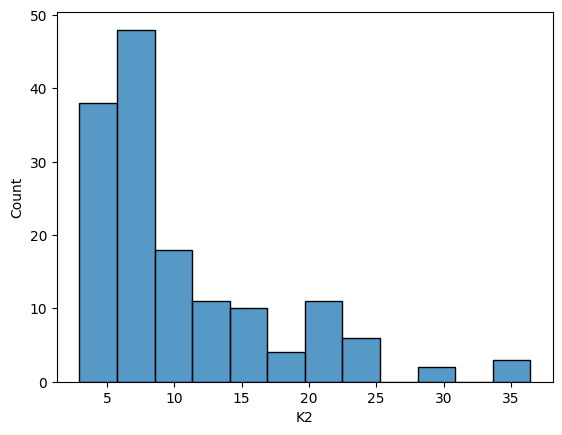

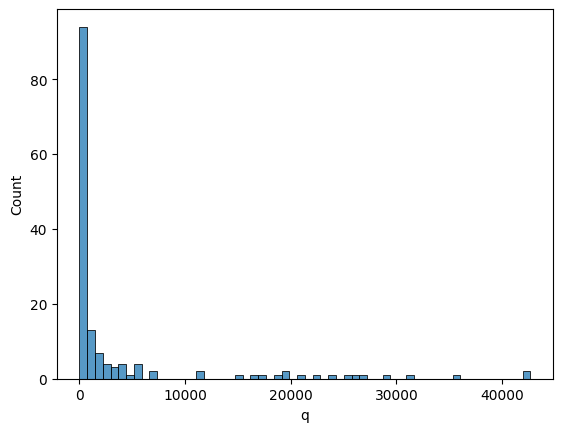

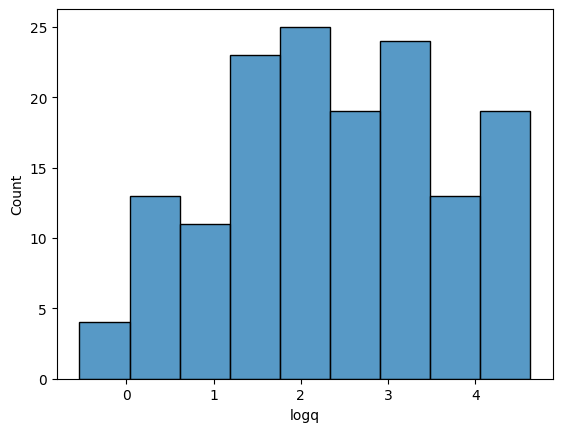

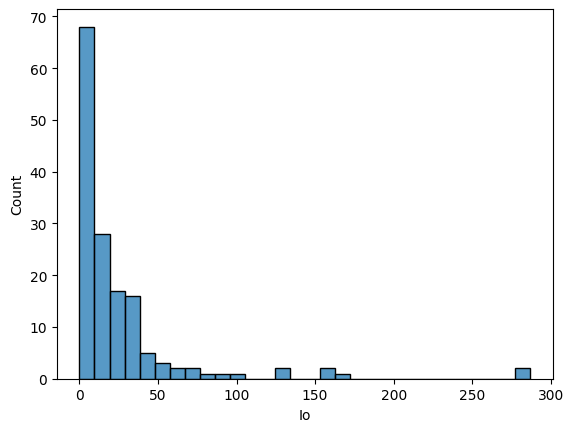

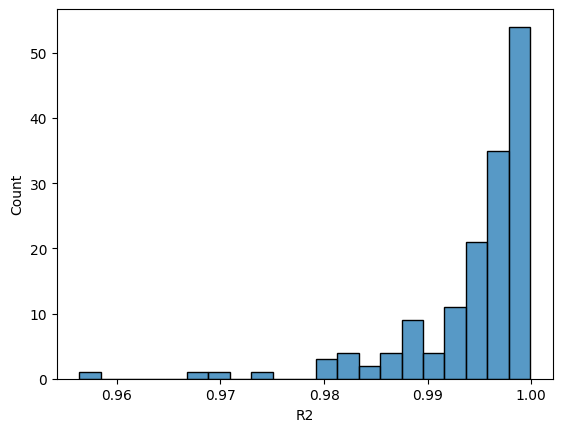

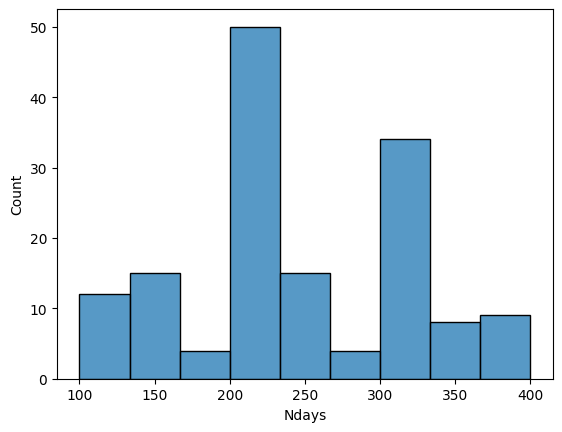

<Axes: xlabel='GDP_per_capita_PPP', ylabel='Count'>

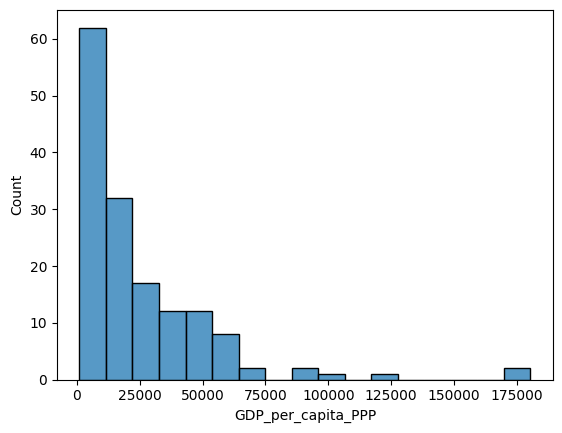

In [18]:
# Plot parameter histograms

sn.histplot(data=tab,x='a')
plt.show()
sn.histplot(data=tab,x='K2')
plt.show()
sn.histplot(data=tab,x='q')
plt.show()
sn.histplot(data=tab,x='logq')
plt.show()
sn.histplot(data=tab,x='Io')
plt.show()
sn.histplot(data=tab,x='R2')
plt.show()
sn.histplot(data=tab,x='Ndays')
plt.show()
sn.histplot(data=tab,x='GDP_per_capita_PPP')

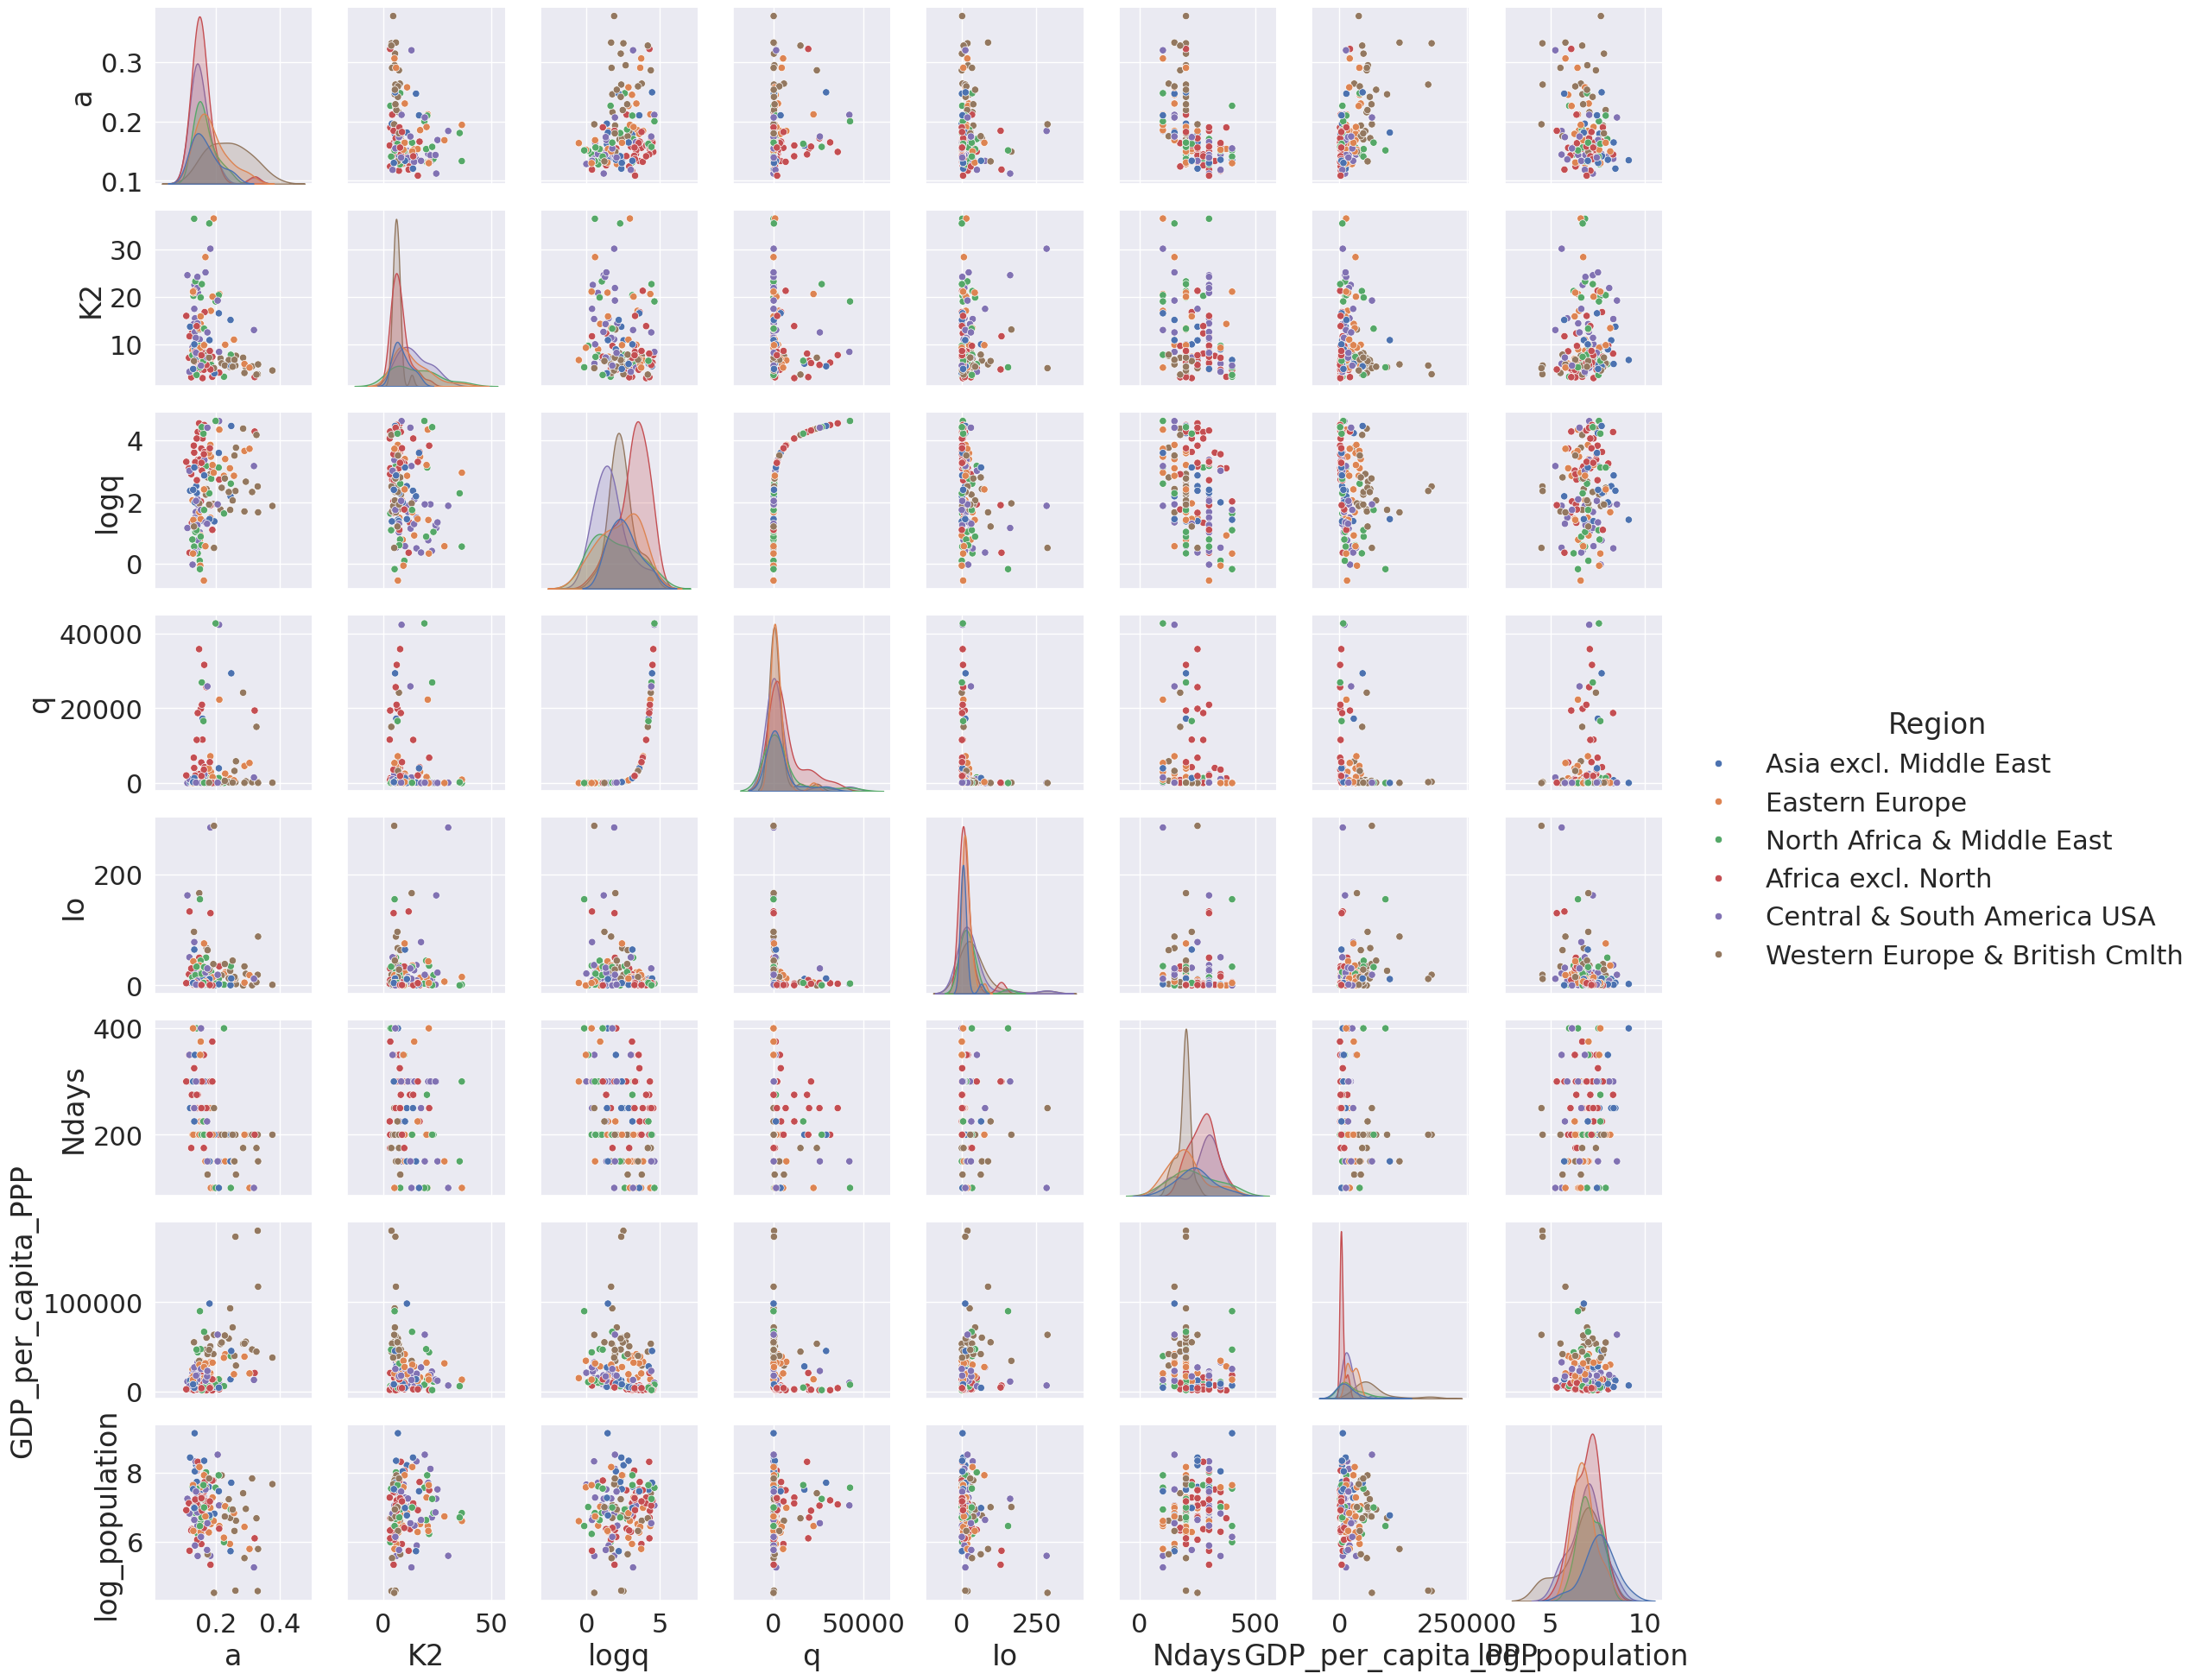

In [19]:
# Plot pairwise plots of parameter values

sn.set(font_scale=2)
sn.pairplot(data=tab[['Region','a','K2','logq','q','Io','Ndays','GDP_per_capita_PPP','log_population']],hue='Region')
plt.show()

In [40]:
# Make country isocode mapping and correct some codes manually

isocodes = pd.read_csv('data/country_isocodes.txt',sep='\t')
countries_iso = list(isocodes['COUNTRY'])
countries_iso2 = list(isocodes['ISO2'])
mapcodes = {}
notfound = []
for c in countries:
    ii = -1
    for i,ciso in enumerate(countries_iso):
        if c in ciso:
            ii = i
            break
    if ii>0:
        #print(c,countries_iso2[i])
        mapcodes[c] = countries_iso2[i]
    else:
        notfound.append(c)
#print(notfound)
mapcodes['Bosnia and Herz.'] = 'BA'
mapcodes['Central African Rep.'] = 'CF'
mapcodes['Dominican Rep.'] = 'DO'
mapcodes['Eq. Guinea'] = 'GQ'
mapcodes['eSwatini'] = 'SZ'
mapcodes['Kosovo'] = 'KS'
mapcodes['S. Sudan'] = 'SD'
mapcodes['Dem. Rep. Congo'] = 'CD'
codes = [mapcodes[c] for c in countries]
tab['ISO2'] = codes
tab.to_csv('output/data4.txt',sep='\t',index=False)

In [22]:
# Map parameter values onto the geographic map

map_a = {}
map_K2 = {}
map_logq = {}
map_GDPcap = {}
for cgis in countries_gis:
    ii = -1
    for i,c in enumerate(countries):
        if cgis==c:
            a = np.float64(tab.loc[tab['Country']==c].a)
            K2 = np.float64(tab.loc[tab['Country']==c].K2)
            logq = np.float64(tab.loc[tab['Country']==c].logq)
            GDPcap = np.float64(tab.loc[tab['Country']==c].GDP_per_capita_PPP)
            map_a[c] = a
            map_K2[c] = K2
            map_logq[c] = logq
            map_GDPcap[c] = GDPcap
            #print(c,a,K2,logq)
for cgis in countries_gis:
    if not cgis in map_a:
        map_a[cgis] = np.nan
        map_K2[cgis] = np.nan
        map_logq[cgis] = np.nan
        map_GDPcap[cgis] = np.nan
            
list_a = [map_a[c] for c in countries_gis]
list_K2 = [map_K2[c] for c in countries_gis]
list_logq = [map_logq[c] for c in countries_gis]
list_GDPcap = [map_GDPcap[c] for c in countries_gis]
world['a'] = list_a
world['K2'] = list_K2
world['logq'] = list_logq
world['GDPcap'] = list_GDPcap

# Uncomment for shozing the table
# display(world)

# Sanity check that the data for GDP in geopandas is the approximately the same as in the input table
# sn.scatterplot(data=world,x='gdp_per_cap',y='GDPcap')

/tmp/ipykernel_12895/3078777067.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  a = np.float64(tab.loc[tab['Country']==c].a)
/tmp/ipykernel_12895/3078777067.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  K2 = np.float64(tab.loc[tab['Country']==c].K2)
/tmp/ipykernel_12895/3078777067.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  logq = np.float64(tab.loc[tab['Country']==c].logq)
/tmp/ipykernel_12895/3078777067.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  GDPcap = np.float64(tab.loc[tab['Country']==c].GDP_per_capita_PPP)


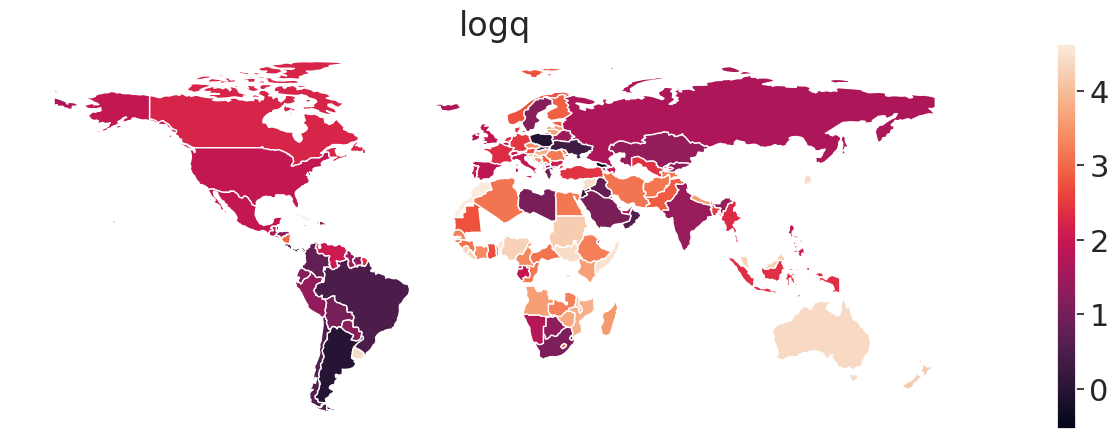

In [27]:
# Plot individual parameters on top of the geographical map

# Uncomment the column for visualization
col = 'logq'
#col = 'GDPcap'
#col = 'gdp_per_cap'
world.plot(column=col,figsize=(20,5), legend=True)
#world.plot(column=col,figsize=(20,20))
plt.axis('off')
plt.title(col)
plt.show()

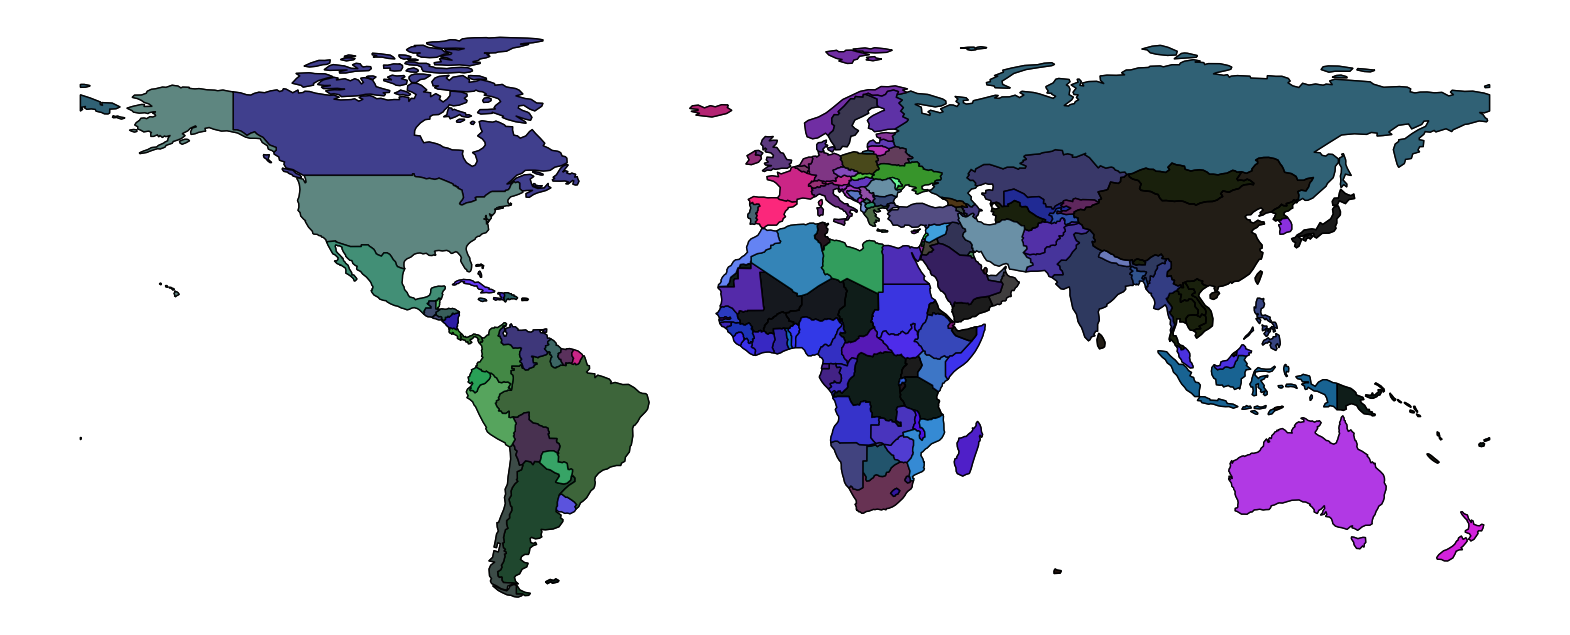

In [33]:
# "Three-dimensional" coloring Red=a, Green=K2, Blue=logq

a = np.array(list_a)
a = a[np.where(1-np.isnan(a))]
a_mx = np.max(a)
a_mn = np.min(a)

K2 = np.array(list_K2)
K2 = K2[np.where(1-np.isnan(K2))]
K2_mx = np.max(K2)
K2_mn = np.min(K2)

logq = np.array(list_logq)
logq = logq[np.where(1-np.isnan(logq))]
logq_mx = np.max(logq)
logq_mn = np.min(logq)

# One can focus on a predefined subset of countries or an explicitly specified subset, 
# if this is needed: uncomment the corresponding line and comment the next one
ax2 = world.plot( figsize=(20,20), edgecolor=u'black', cmap='Set2' )

#ax2 = world[world.continent == 'Africa'].plot(figsize=(8,8), edgecolor=u'gray', cmap='Pastel1')
#ax2 = world[world.continent == 'North America'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'South America'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'Oceania'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'Asia'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')

# visualizing a subset
#selection = world.continent == 'Europe'
#selection[world.name == 'Russia'] = False
#ax2 = world[selection].plot(figsize=(20,20), edgecolor=u'gray', cmap='Pastel1')


for c in countries_gis:
    a = (map_a[c]-a_mn)/(a_mx-a_mn)
    K2 = (map_K2[c]-K2_mn)/(K2_mx-K2_mn)
    logq = (map_logq[c]-logq_mn)/(logq_mx-logq_mn)
    if np.isnan(a):
        plotCountryPatch(ax2, c, 'black')
    else:
        plotCountryPatch(ax2, c, [a,K2,logq])
        #plotCountryPatch(ax2, c, [1-a,1-K2,1-logq])
    
plt.axis('off')
plt.show()

/tmp/ipykernel_12895/416618144.py:6: DeprecationWarning: Please use `zscore` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  X = stats.zscore(X)


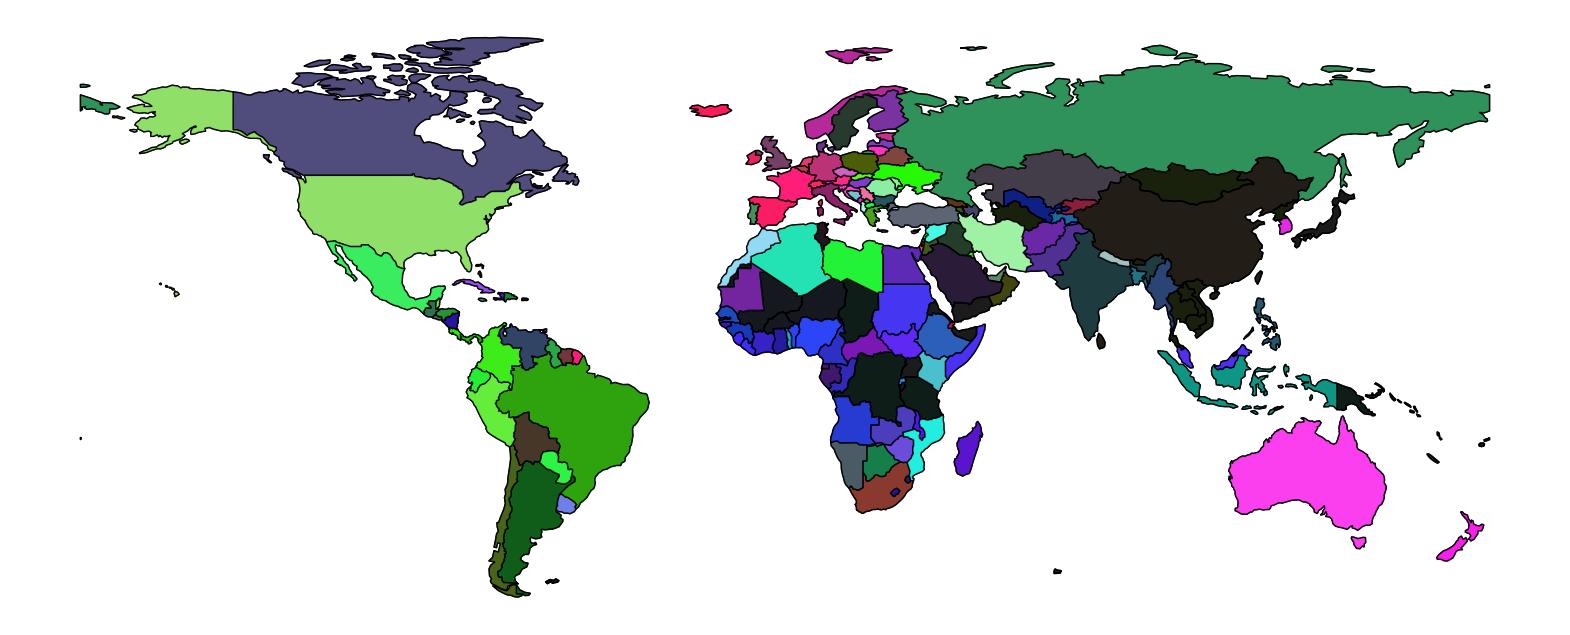

In [37]:
# Loading the coordinates on the elastic map, and create "two-dimensional" coloring
# where countries with close projections on elastic map have similar color

coords = np.loadtxt('data/data3_proj.txt')
X = tab[['a','K2','logq','GDP_per_capita_PPP']].to_numpy()
X = stats.zscore(X)

Xw = winsorize(X,axis=0,limits=[0.1,0.1])
mn = np.min(Xw,axis=0)
mx = np.max(Xw,axis=0)

map_countries = {}
for cgis in countries_gis:
    ii = -1
    for i,c in enumerate(countries):
        if cgis==c:
            map_countries[c] = i
for cgis in countries_gis:
    if not cgis in map_countries:
        map_countries[cgis] = np.nan
            
list_countries = [map_countries[c] for c in countries_gis]

ax2 = world.plot( figsize=(20,20), edgecolor=u'black', cmap='Set2' )
#selection = world.continent == 'Europe'
#selection[world.name == 'Russia'] = False
#ax2 = world[selection].plot(figsize=(20,20), edgecolor=u'gray', cmap='Pastel1')
#ax2 = world[world.continent == 'Africa'].plot(figsize=(8,8), edgecolor=u'gray', cmap='Pastel1')
#ax2 = world[world.continent == 'North America'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'South America'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'Oceania'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'Asia'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')

for c in countries_gis:
    if np.isnan(map_countries[c]):
        plotCountryPatch(ax2, c, 'black')
    else:
        a = (Xw[map_countries[c],0]-mn[0])/(mx[0]-mn[0])
        K2 = (Xw[map_countries[c],1]-mn[1])/(mx[1]-mn[1])
        logq = (Xw[map_countries[c],2]-mn[2])/(mx[2]-mn[2])
        plotCountryPatch(ax2, c, [a,K2,logq])

plt.axis('off')
plt.show()

Shape of the PCA matrix: (151, 3)


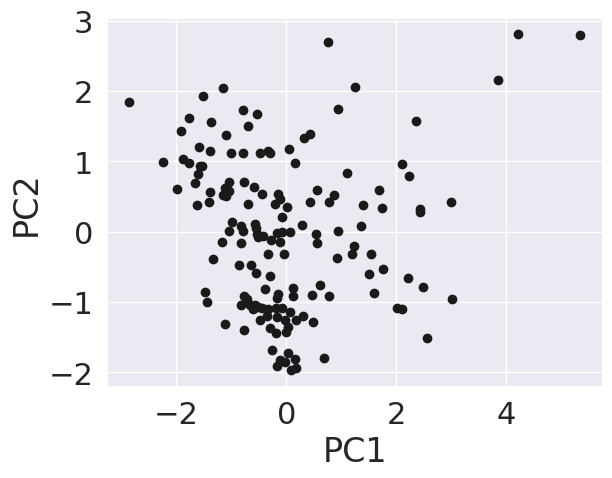

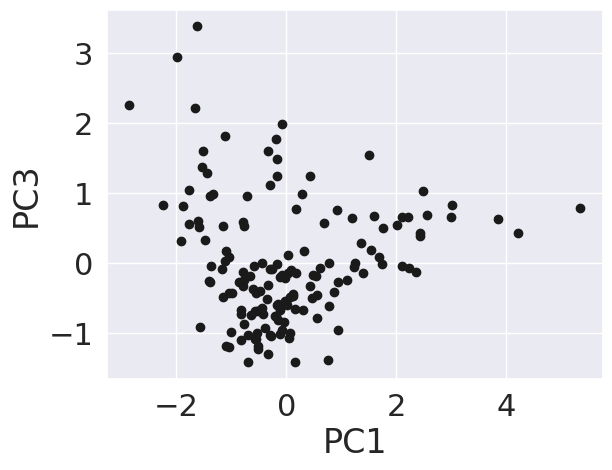

In [44]:
# Compute PCA for the dataset
pca = PCA(n_components=3)
u = pca.fit_transform(X)
print('Shape of the PCA matrix:',u.shape)
plt.plot(u[:,0],u[:,1],'ko')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
plt.plot(u[:,0],u[:,2],'ko')
plt.xlabel('PC1')
plt.ylabel('PC3')
plt.show()

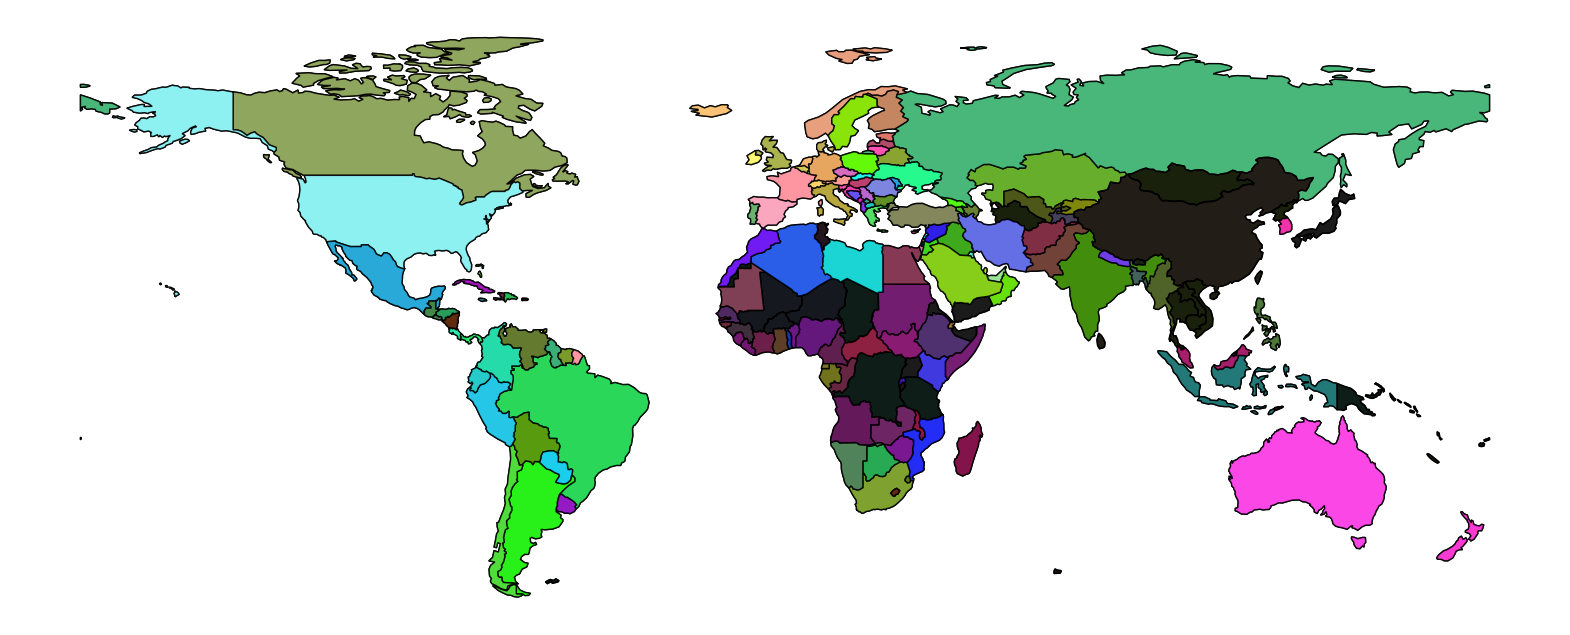

In [46]:
# Create "Three-dimensional" PCA coloring 

pca = PCA(n_components=3)
u = pca.fit_transform(X)
u[:,0] = winsorize(u[:,0],limits=[0.1,0.1])
u[:,1] = winsorize(u[:,1],limits=[0.1,0.1])
u[:,2] = winsorize(u[:,2],limits=[0.1,0.1])
mn = np.min(u,axis=0)
mx = np.max(u,axis=0)

map_countries = {}
for cgis in countries_gis:
    ii = -1
    for i,c in enumerate(countries):
        if cgis==c:
            map_countries[c] = i
for cgis in countries_gis:
    if not cgis in map_countries:
        map_countries[cgis] = np.nan
            
list_countries = [map_countries[c] for c in countries_gis]

#world['PC1'] = u[:,0]
#world['PC2'] = u[:,1]
#world['PC3'] = u[:,2]

ax2 = world.plot( figsize=(20,20), edgecolor=u'black', cmap='Set2' )
#selection = world.continent == 'Europe'
#selection[world.name == 'Russia'] = False
#ax2 = world[selection].plot(figsize=(20,20), edgecolor=u'gray', cmap='Pastel1')
#ax2 = world[world.continent == 'Africa'].plot(figsize=(8,8), edgecolor=u'gray', cmap='Pastel1')
#ax2 = world[world.continent == 'North America'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'South America'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'Oceania'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')
#ax2 = world[world.continent == 'Asia'].plot(figsize=(20,20), edgecolor=u'black', cmap='Pastel1')

for c in countries_gis:
    if np.isnan(map_countries[c]):
        plotCountryPatch(ax2, c, 'black')
    else:
        pc1 = (u[map_countries[c],0]-mn[0])/(mx[0]-mn[0])
        pc2 = (u[map_countries[c],1]-mn[1])/(mx[1]-mn[1])
        pc3 = (u[map_countries[c],2]-mn[2])/(mx[2]-mn[2])
        plotCountryPatch(ax2, c, [pc1,pc2,pc3])

plt.axis('off')
plt.show()

/tmp/ipykernel_12895/2915536912.py:14: DeprecationWarning: Please use `zscore` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  X = stats.zscore(X)


151


100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:42<00:00,  2.36s/it]


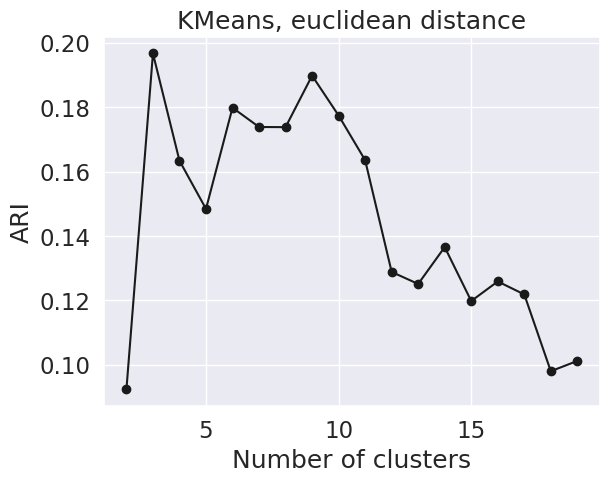

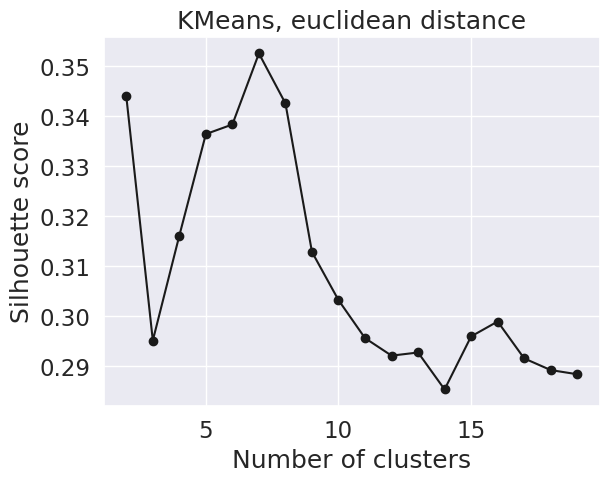

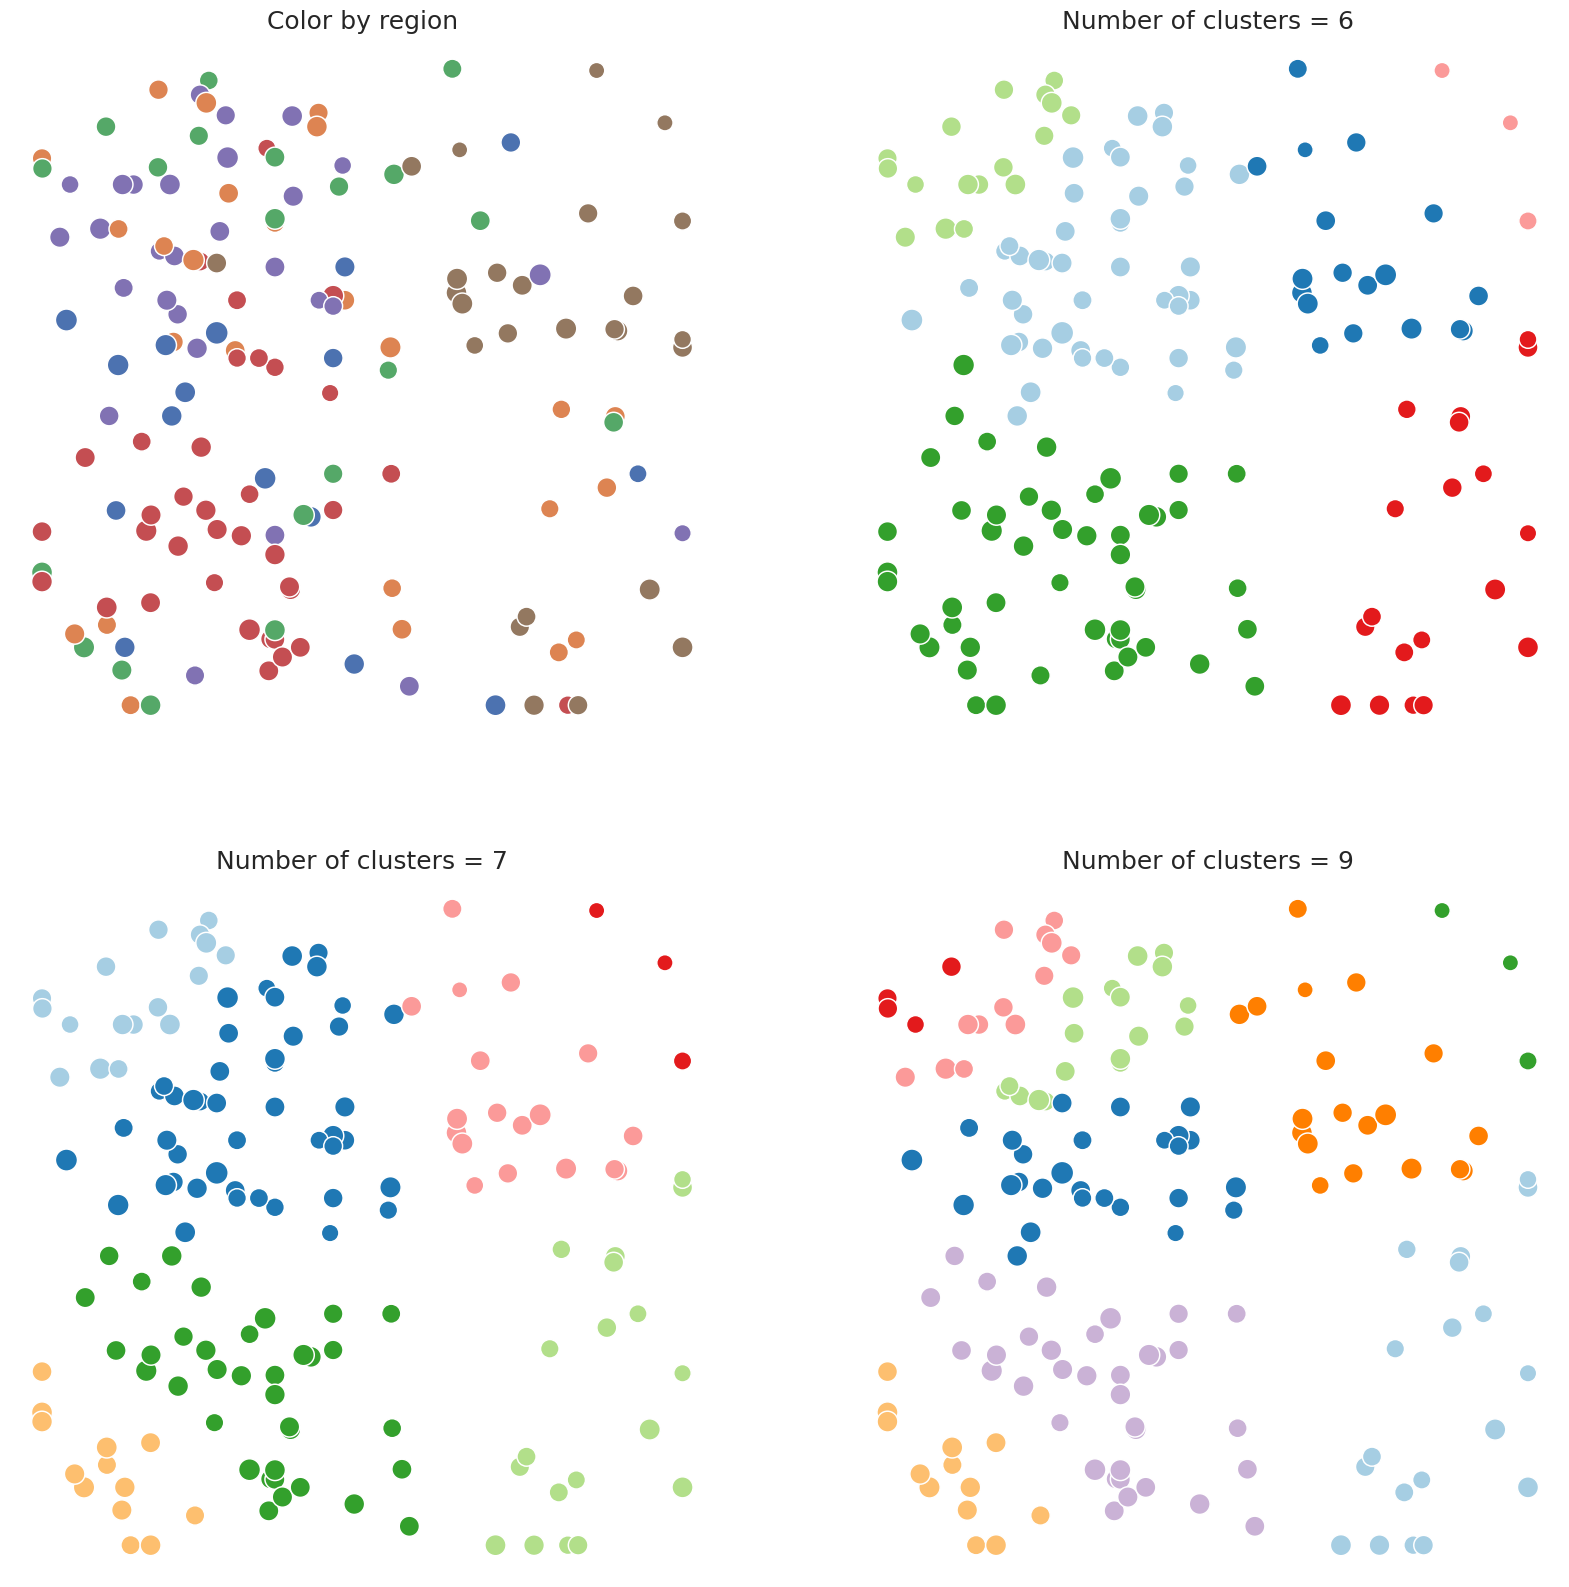

In [53]:
# Perform clustering and compute clustering quality criteria

classes = list(tab['Region'])
print(len(classes))
logpop = np.array(list(tab['log_population']))

#coords = np.loadtxt('/mnt/c/Datas/COVID_model/data2_proj.txt')
#X = tab[['a','K2','logq']].to_numpy()
#coords = np.loadtxt('/mnt/c/Datas/COVID_model/data1_proj.txt')
#X = tab[['a','K2','logq','Io','Ndays']].to_numpy()
coords = np.loadtxt('data/data3_proj.txt')
X = tab[['a','K2','logq','GDP_per_capita_PPP']].to_numpy()

X = stats.zscore(X)
aris_kmeans_euclidean = []
sil_kmeans_euclidean = []
labels_kmeans_euclidean = []
nclusters = np.arange(2,20)
for nc in tqdm(nclusters):
    kmeans = KMeans(n_clusters=nc, random_state=0,n_init=1000).fit(X)
    labels_kmeans_euclidean.append(kmeans.labels_)
    ari = adjusted_rand_score(classes,kmeans.labels_)
    sil = silhouette_score(X,kmeans.labels_)
    aris_kmeans_euclidean.append(ari)
    sil_kmeans_euclidean.append(sil)
    
sn.set(font_scale=1.5)
plt.plot(nclusters,aris_kmeans_euclidean,'ko-')
plt.xlabel('Number of clusters')
plt.title('KMeans, euclidean distance')
plt.ylabel('ARI')
plt.show()

sn.set(font_scale=1.5)
plt.plot(nclusters,sil_kmeans_euclidean,'ko-')
plt.xlabel('Number of clusters')
plt.title('KMeans, euclidean distance')
plt.ylabel('Silhouette score')
plt.show()

#sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes},size='logpop',color='Region')
sn.set(font_scale=1.5)
fig, ax = plt.subplots(2,2,figsize=(20,20))
plt.subplot(221)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes},x='x',y='y',hue='Region',legend=False,s=logpop*30)
plt.axis('off')
plt.title('Color by region')

num = 6
k = np.where(nclusters==num)[0][0]
plt.subplot(222)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels_kmeans_euclidean[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))

num = 7
k = np.where(nclusters==num)[0][0]
plt.subplot(223)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels_kmeans_euclidean[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))

num = 9
k = np.where(nclusters==num)[0][0]
plt.subplot(224)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels_kmeans_euclidean[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))


plt.show()

/tmp/ipykernel_12895/3885521958.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Paired')


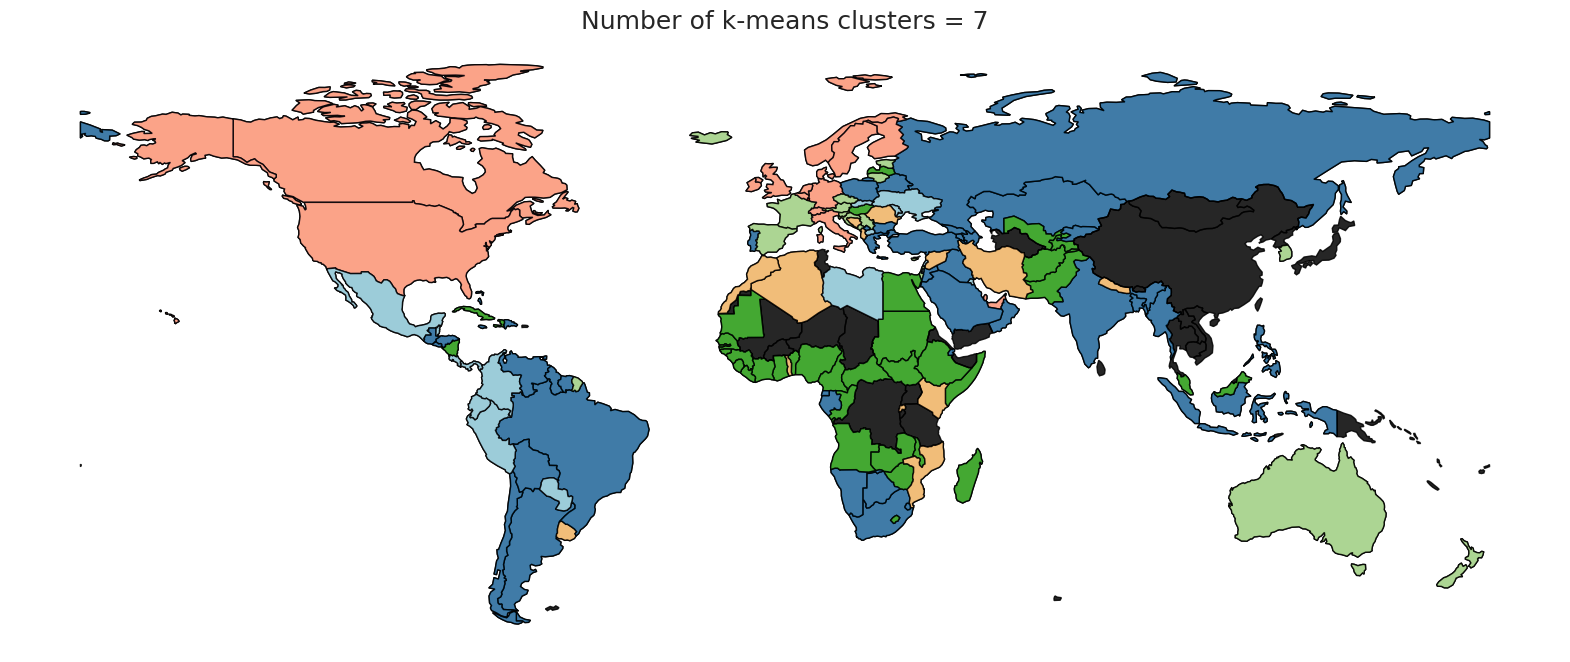

In [54]:
# Color geographical map by clusters

import matplotlib
cmap = matplotlib.cm.get_cmap('Paired')

num = 7
k = np.where(nclusters==num)[0][0]
clusters = labels_kmeans_euclidean[k]

map_cluster = {}
for cgis in countries_gis:
    ii = -1
    for i,c in enumerate(countries):
        if cgis==c:
            map_cluster[c] = clusters[i]
for cgis in countries_gis:
    if not cgis in map_cluster:
        map_cluster[cgis] = np.nan
            
list_cluster = [map_cluster[c] for c in countries_gis]
world['cluster'] = list_cluster

ax2 = world.plot(column='cluster',figsize=(20,20), edgecolor=u'black', cmap='Set2' )
for c in countries_gis:
    cl = map_cluster[c]
    if np.isnan(a):
        plotCountryPatch(ax2, c, 'white')
    else:
        plotCountryPatch(ax2, c, cmap(cl))

plt.axis('off')
plt.title('Number of k-means clusters = '+str(num))
plt.show()

In [69]:
# Produce clustering table of KMeans clustering

nums = [6,7,8,9,10]

cl_results = pd.DataFrame(data={'Country':original_names})
for n in nums:
    k = np.where(nclusters==n)[0][0]
    cl_results['Kmeans_eucl_'+str(n)] = labels_kmeans_euclidean[k]

display(cl_results)
cl_results.to_csv('output/Kmeans_3plusGDP_eucl.txt',sep='\t',index=False)

Country  Kmeans_eucl_6  Kmeans_eucl_7  Kmeans_eucl_8  Kmeans_eucl_9  \
0    Afghanistan              3              3              0              8   
1        Albania              3              6              4              6   
2        Algeria              3              6              4              6   
3         Angola              3              3              0              8   
4      Argentina              0              1              3              2   
..           ...            ...            ...            ...            ...   
146      Uruguay              3              6              4              6   
147   Uzbekistan              0              3              0              1   
148    Venezuela              0              1              3              1   
149       Zambia              3              3              0              8   
150     Zimbabwe              3              3              0              8   

     Kmeans_eucl_10  
0                 9  
1                 8  
2                 8  
3                 9  
4                 5  
..              ...  
146               8  
147               1  
148               1  
149               9  
150               9  

[151 rows x 6 columns]

151
optimal eps= 0.51 number of clusters= 4


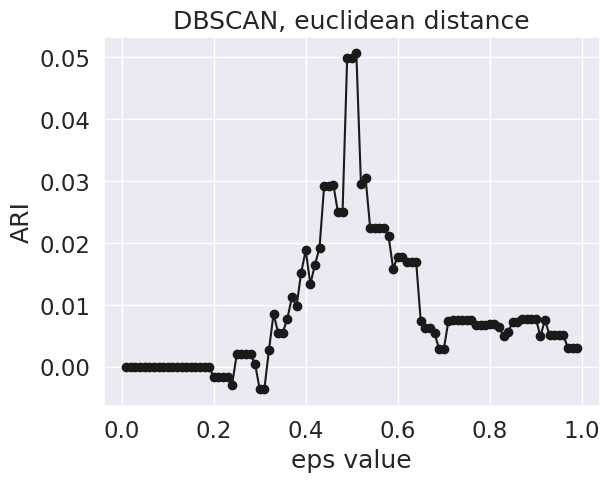

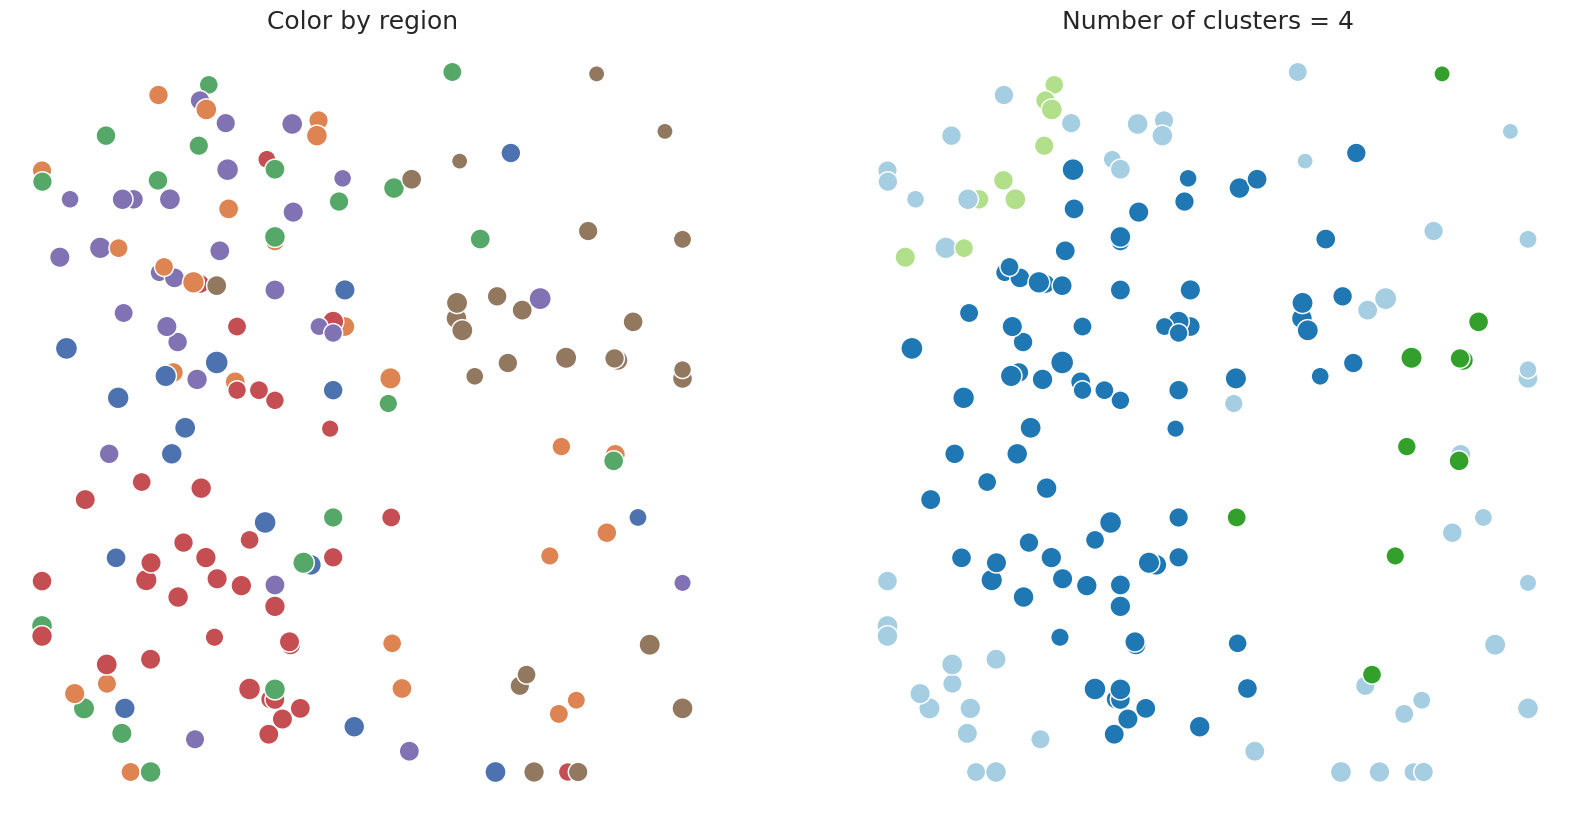

In [57]:
# Apply DBSCAN clustering

import scipy
import scipy.stats as stats
from sklearn.cluster import DBSCAN
from sklearn.metrics.cluster import adjusted_rand_score

classes = list(tab['Region'])
print(len(classes))
logpop = np.array(list(tab['log_population']))

coords = np.loadtxt('data/data3_proj.txt')

X = tab[['a','K2','logq']].to_numpy()
X = stats.zscore(X)

aris_DBSCAN_euclidean = []
labels_DBSCAN_euclidean = []
eps_values = np.arange(0.01,1.0,0.01)
for eps in eps_values:
    dbscan = DBSCAN(eps=eps).fit(X)
    labels_DBSCAN_euclidean.append(dbscan.labels_)
    ari = adjusted_rand_score(classes,dbscan.labels_)
    aris_DBSCAN_euclidean.append(ari)
    
k = np.argmax(aris_DBSCAN_euclidean)
print('optimal eps=',eps_values[k],'number of clusters=',len(set(labels_DBSCAN_euclidean[k])))
    
sn.set(font_scale=1.5)
plt.plot(eps_values,aris_DBSCAN_euclidean,'ko-')
plt.xlabel('eps value')
plt.title('DBSCAN, euclidean distance')
plt.ylabel('ARI')
plt.show()

sn.set(font_scale=1.5)
fig, ax = plt.subplots(1,2,figsize=(20,10))
plt.subplot(121)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes},x='x',y='y',hue='Region',legend=False,s=logpop*30)
plt.axis('off')
plt.title('Color by region')

plt.subplot(122)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels_DBSCAN_euclidean[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = 4')


plt.show()

151


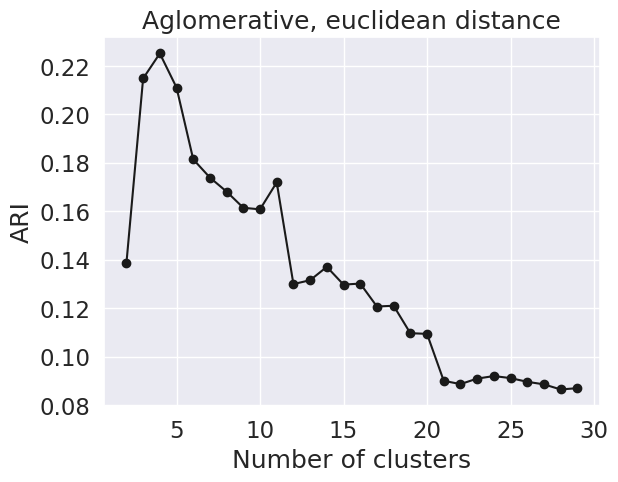

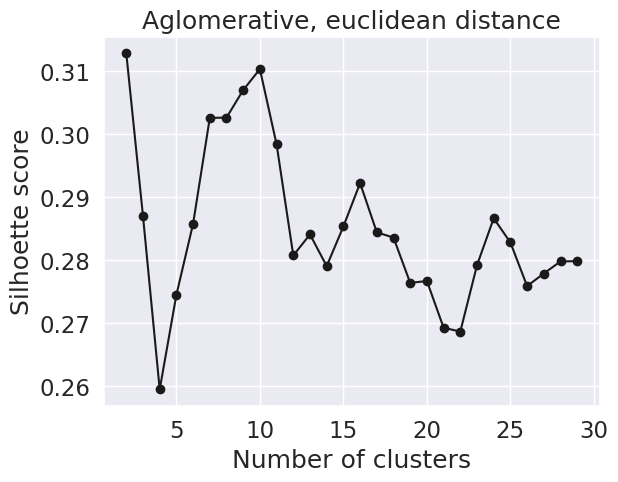

nclusters [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29]


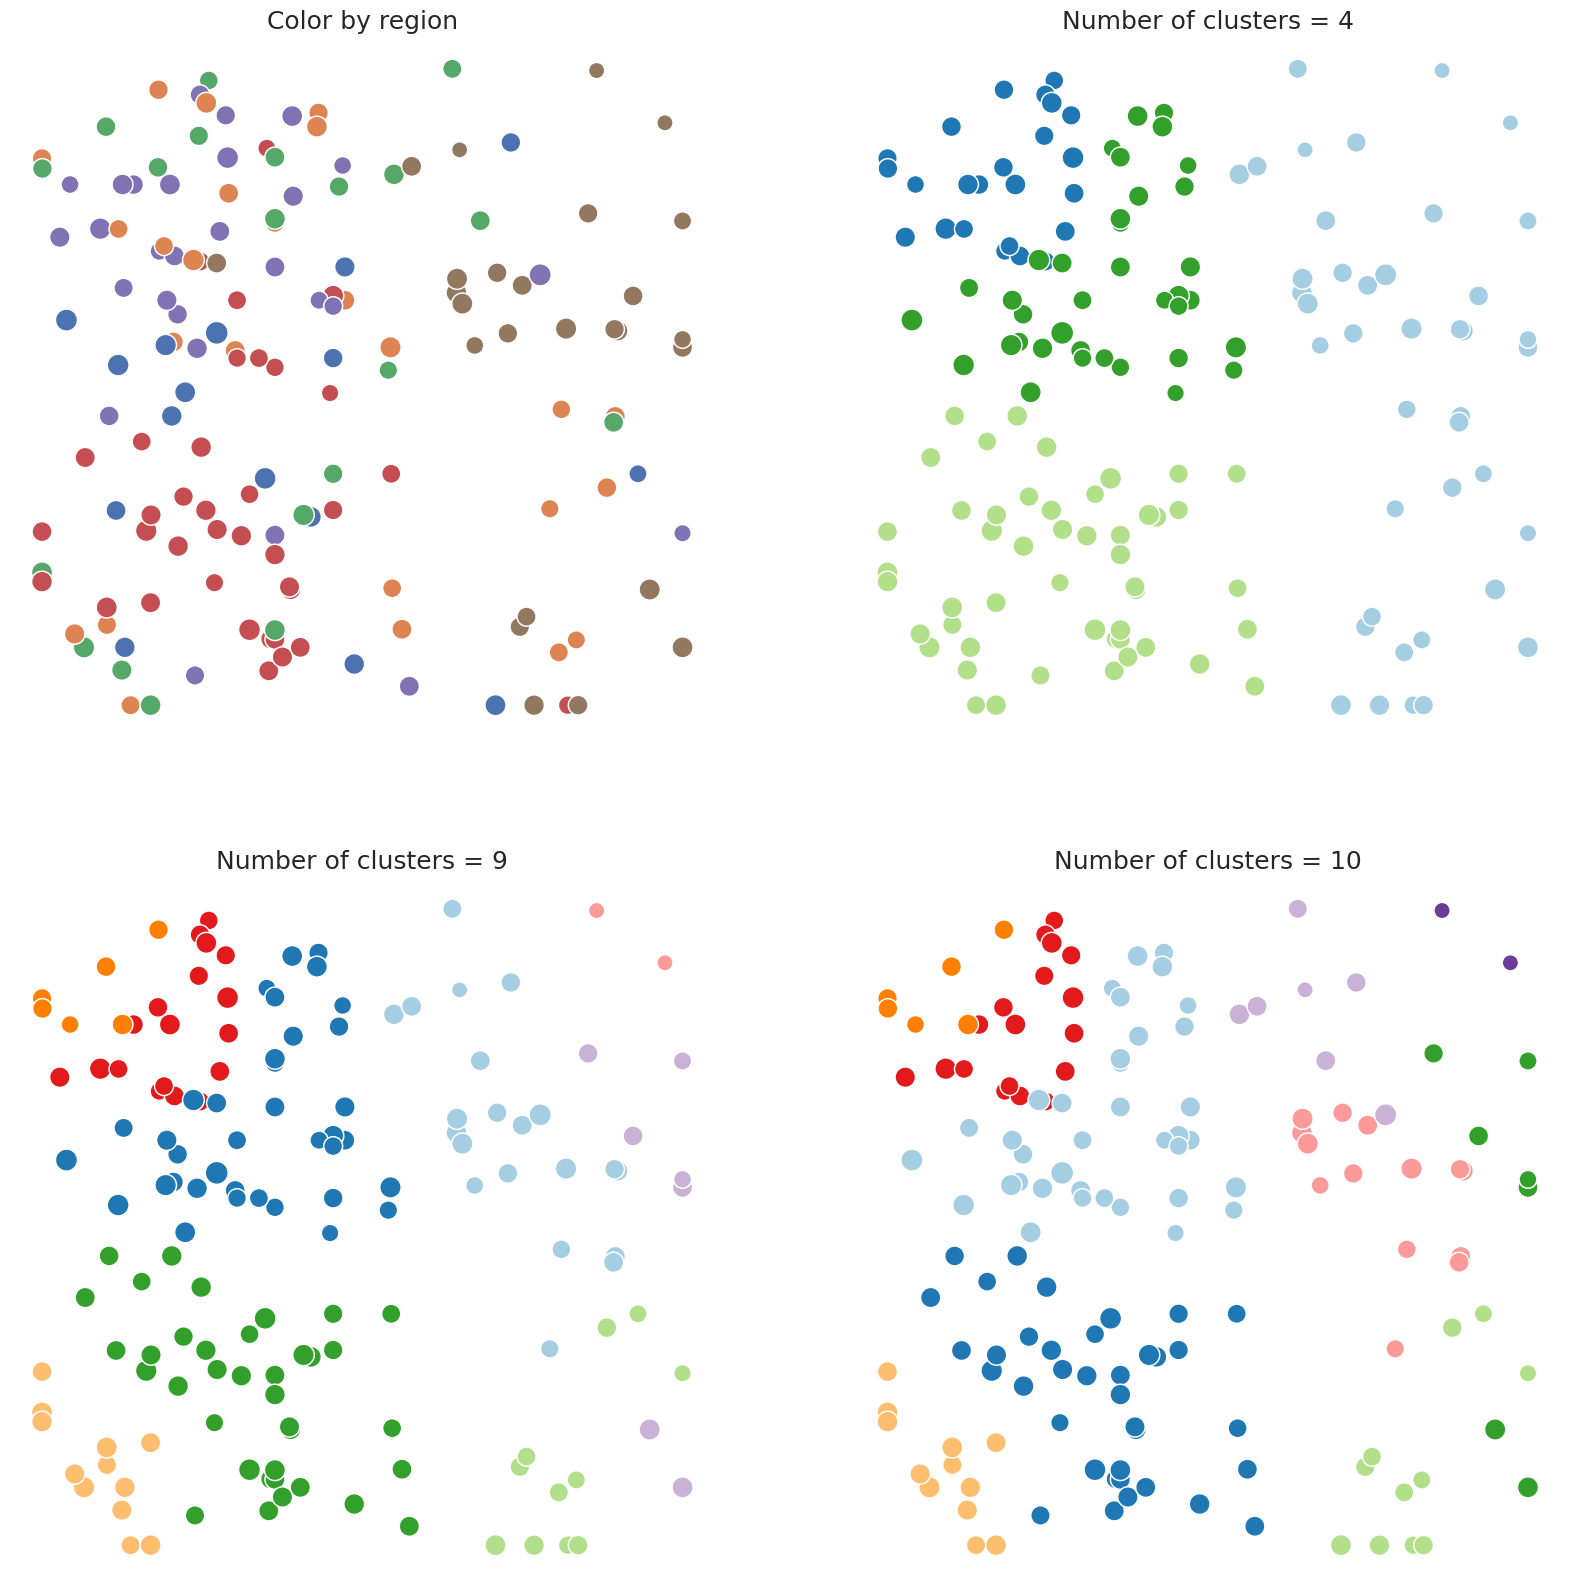

In [59]:
# Apply hierarchical clustering

import scipy
import scipy.stats as stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score

classes = list(tab['Region'])
print(len(classes))
logpop = np.array(list(tab['log_population']))

#coords = np.loadtxt('/mnt/c/Datas/COVID_model/data2_proj.txt')
#X = tab[['a','K2','logq']].to_numpy()
#coords = np.loadtxt('/mnt/c/Datas/COVID_model/data1_proj.txt')
#X = tab[['a','K2','logq','Io','Ndays']].to_numpy()
coords = np.loadtxt('data/data3_proj.txt')
X = tab[['a','K2','logq','GDP_per_capita_PPP']].to_numpy()



X = stats.zscore(X)
aris = []
sils = []
labels = []
nclusters = np.arange(2,30)
for nc in nclusters:
    clustering = AgglomerativeClustering(n_clusters=nc).fit(X)
    labels.append(clustering.labels_)
    ari = adjusted_rand_score(classes,clustering.labels_)
    aris.append(ari)
    sil = silhouette_score(X,clustering.labels_)
    sils.append(sil)
    
    
sn.set(font_scale=1.5)
plt.plot(nclusters,aris,'ko-')
plt.xlabel('Number of clusters')
plt.title('Aglomerative, euclidean distance')
plt.ylabel('ARI')
plt.show()

sn.set(font_scale=1.5)
plt.plot(nclusters,sils,'ko-')
plt.xlabel('Number of clusters')
plt.title('Aglomerative, euclidean distance')
plt.ylabel('Silhoette score')
plt.show()

#sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes},size='logpop',color='Region')
sn.set(font_scale=1.5)
fig, ax = plt.subplots(2,2,figsize=(20,20))
plt.subplot(221)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes},x='x',y='y',hue='Region',legend=False,s=logpop*30)
plt.axis('off')
plt.title('Color by region')

num = 4
print('nclusters',nclusters)
k = np.where(nclusters==num)[0][0]
plt.subplot(222)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))

num = 9
k = np.where(nclusters==num)[0][0]
plt.subplot(223)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))

num = 10
k = np.where(nclusters==num)[0][0]
plt.subplot(224)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))

plt.show()

/tmp/ipykernel_12895/3849509500.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Paired')


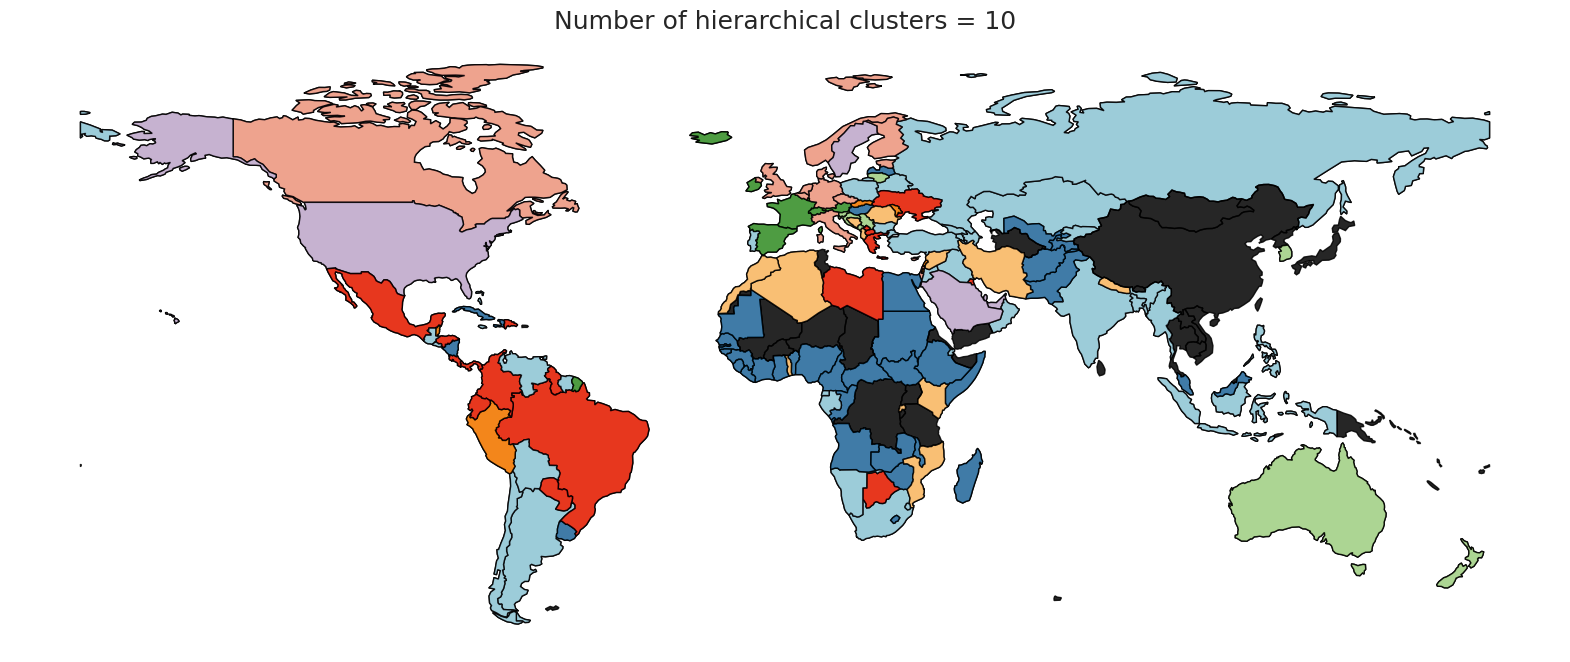

In [60]:
# Color the map using hierarchical clustering

import matplotlib
cmap = matplotlib.cm.get_cmap('Paired')

num = 10
k = np.where(nclusters==num)[0][0]
clusters = labels[k]

map_cluster = {}
for cgis in countries_gis:
    ii = -1
    for i,c in enumerate(countries):
        if cgis==c:
            map_cluster[c] = clusters[i]
for cgis in countries_gis:
    if not cgis in map_cluster:
        map_cluster[cgis] = np.nan
            
list_cluster = [map_cluster[c] for c in countries_gis]
world['cluster'] = list_cluster

ax2 = world.plot(column='cluster',figsize=(20,20), edgecolor=u'black', cmap='Set2' )
for c in countries_gis:
    cl = map_cluster[c]
    if np.isnan(a):
        plotCountryPatch(ax2, c, 'white')
    else:
        plotCountryPatch(ax2, c, cmap(cl))

plt.axis('off')
plt.title('Number of hierarchical clusters = '+str(num))
plt.show()

In [70]:
# Produce table of hierarchical clusters

nums = [5,9,10]

cl_results = pd.DataFrame(data={'Country':original_names})
for n in nums:
    k = np.where(nclusters==n)[0][0]
    cl_results['Aglomerative_eucl_'+str(n)] = labels_kmeans_euclidean[k]

display(cl_results)
cl_results.to_csv('output/Aglomerative_eucl.txt',sep='\t',index=False)

Country  Aglomerative_eucl_5  Aglomerative_eucl_9  \
0    Afghanistan                    0                    8   
1        Albania                    0                    6   
2        Algeria                    2                    6   
3         Angola                    0                    8   
4      Argentina                    4                    2   
..           ...                  ...                  ...   
146      Uruguay                    0                    6   
147   Uzbekistan                    4                    1   
148    Venezuela                    4                    1   
149       Zambia                    0                    8   
150     Zimbabwe                    0                    8   

     Aglomerative_eucl_10  
0                       9  
1                       8  
2                       8  
3                       9  
4                       5  
..                    ...  
146                     8  
147                     1  
148                     1  
149                     9  
150                     9  

[151 rows x 4 columns]

151


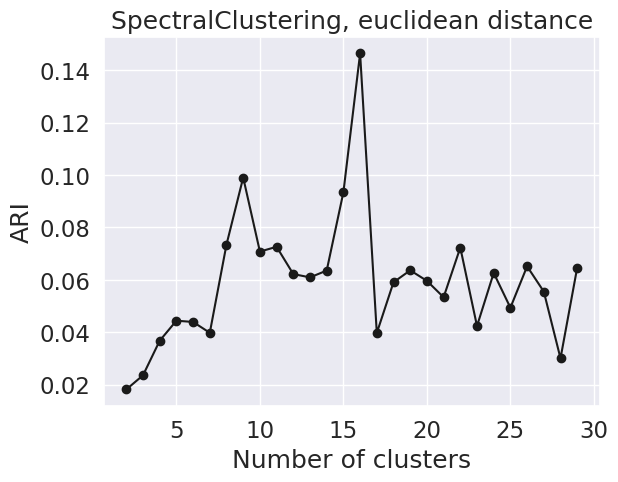

nclusters [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29]


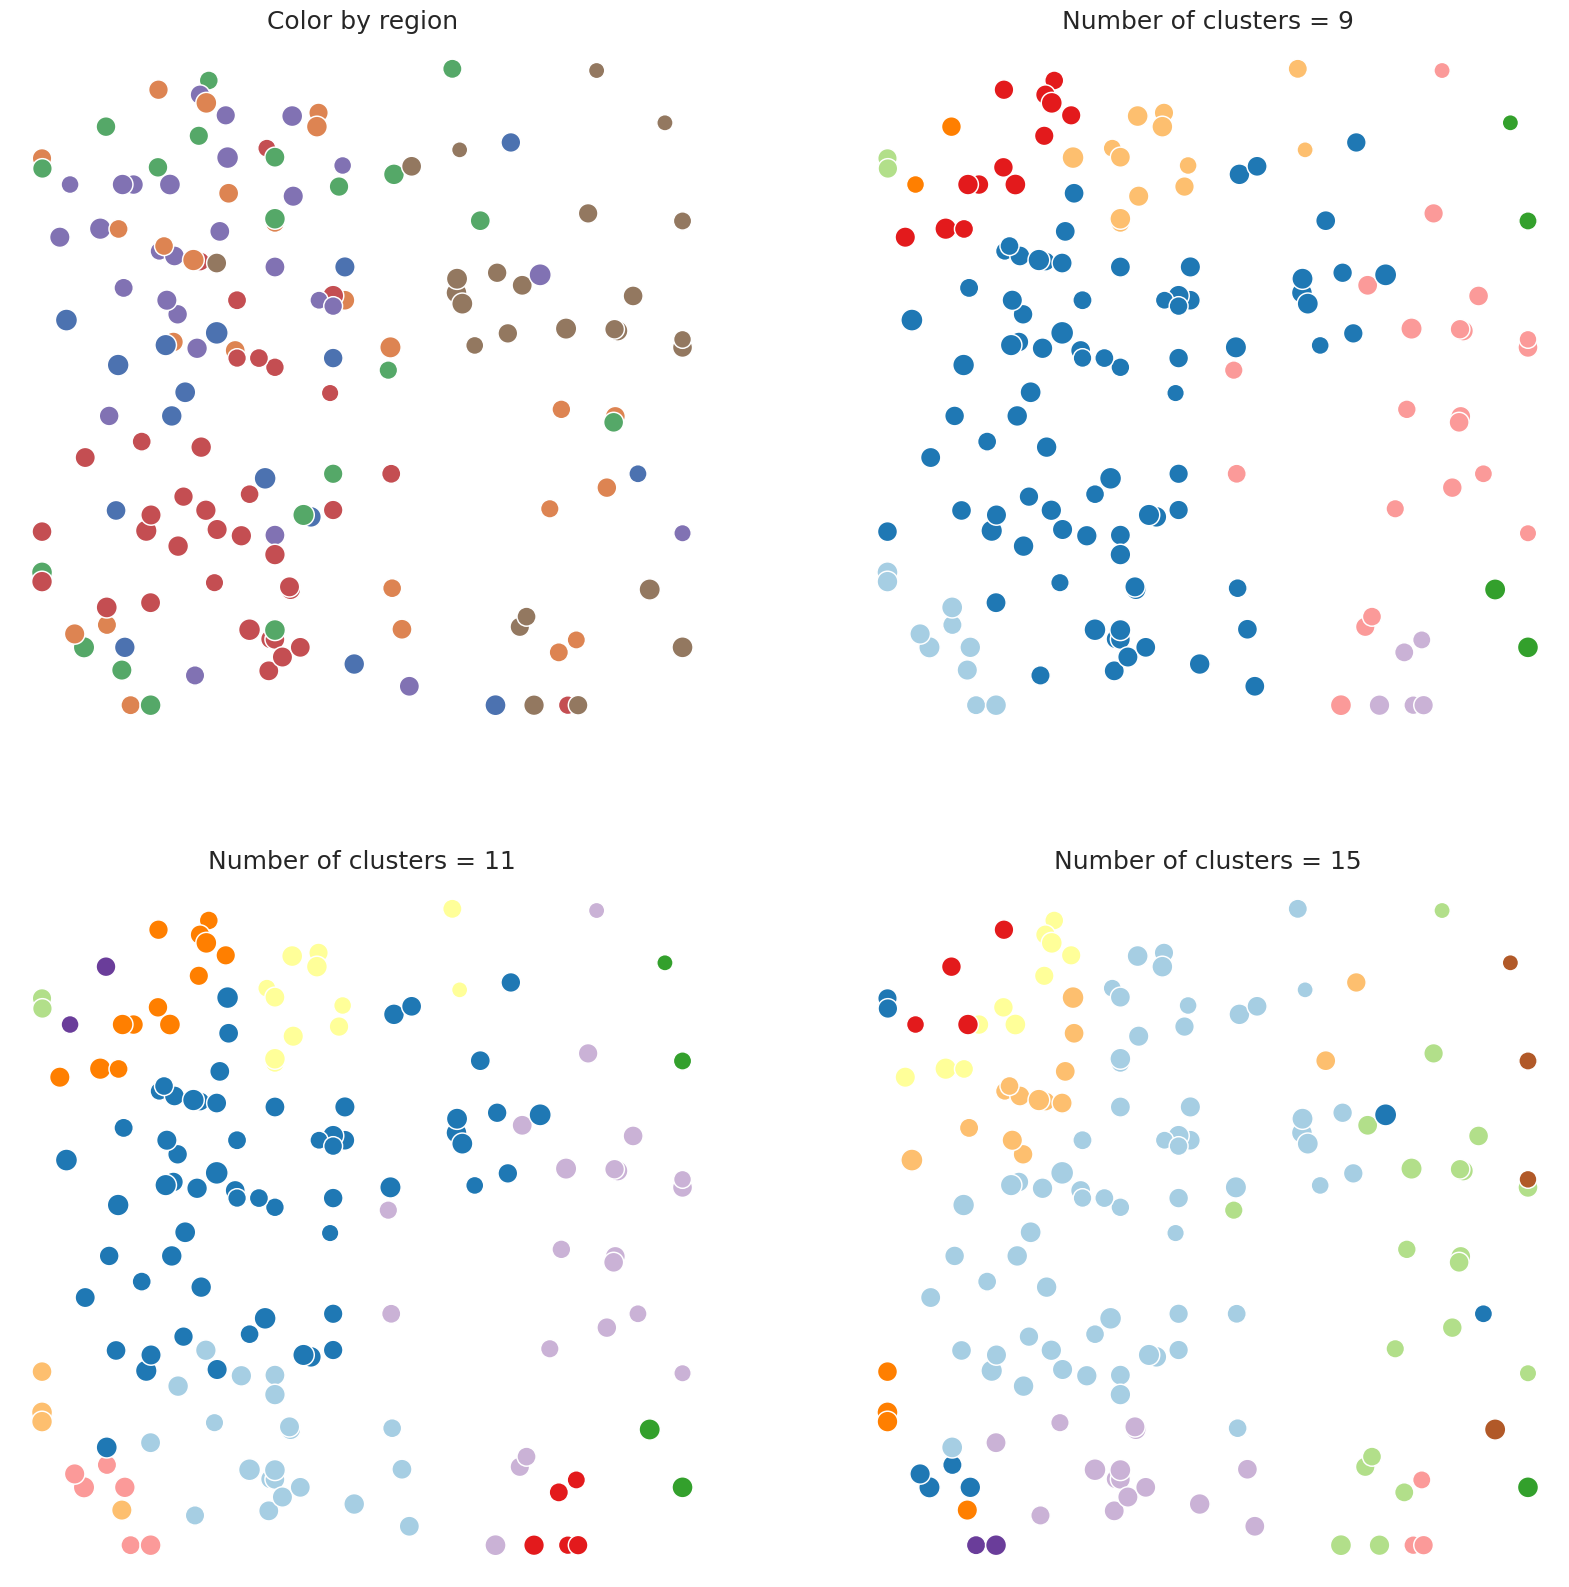

In [63]:
# Apply spectral clustering

import scipy
import scipy.stats as stats
from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import adjusted_rand_score

classes = list(tab['Region'])
print(len(classes))
logpop = np.array(list(tab['log_population']))

coords = np.loadtxt('data/data3_proj.txt')

X = tab[['a','K2','logq']].to_numpy()
X = stats.zscore(X)
aris = []
labels = []
nclusters = np.arange(2,30)
for nc in nclusters:
    clustering = SpectralClustering(n_clusters=nc,random_state=0).fit(X)
    labels.append(clustering.labels_)
    ari = adjusted_rand_score(classes,clustering.labels_)
    aris.append(ari)
    
sn.set(font_scale=1.5)
plt.plot(nclusters,aris,'ko-')
plt.xlabel('Number of clusters')
plt.title('SpectralClustering, euclidean distance')
plt.ylabel('ARI')
plt.show()

#sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes},size='logpop',color='Region')
sn.set(font_scale=1.5)
fig, ax = plt.subplots(2,2,figsize=(20,20))
plt.subplot(221)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes},x='x',y='y',hue='Region',legend=False,s=logpop*30)
plt.axis('off')
plt.title('Color by region')

num = 9
print('nclusters',nclusters)
k = np.where(nclusters==num)[0][0]
plt.subplot(222)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))

num = 11
k = np.where(nclusters==num)[0][0]
plt.subplot(223)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))

num = 15
k = np.where(nclusters==num)[0][0]
plt.subplot(224)
sn.scatterplot(data={'x':coords[:,0],'y':coords[:,1],'logpop':logpop,'Region':classes,'cluster':labels[k]},x='x',y='y',hue='cluster',legend=False,s=logpop*30,palette='Paired')
plt.axis('off')
plt.title('Number of clusters = '+str(num))

plt.show()

/tmp/ipykernel_12895/3639728704.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('Paired')


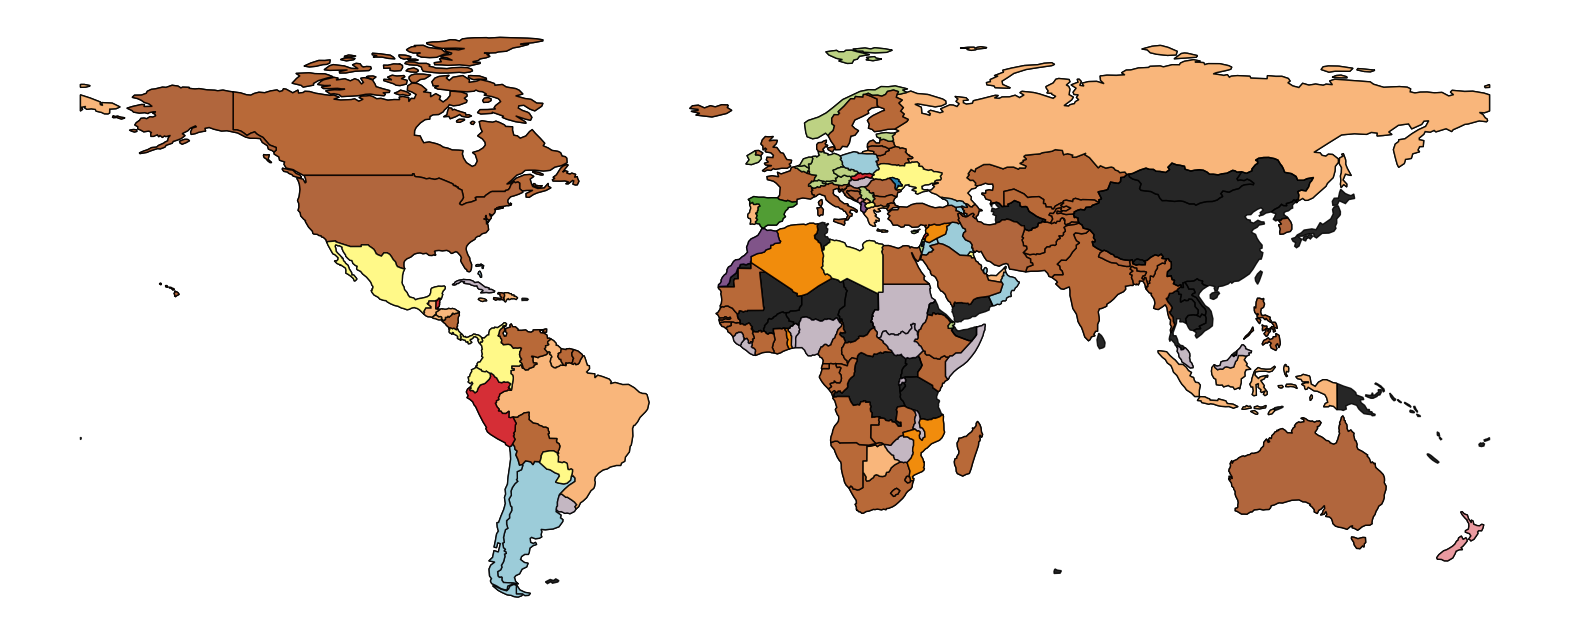

In [64]:
# Plot spectral clusters

import matplotlib
cmap = matplotlib.cm.get_cmap('Paired')

num = 15
k = np.where(nclusters==num)[0][0]
clusters = labels[k]

map_cluster = {}
for cgis in countries_gis:
    ii = -1
    for i,c in enumerate(countries):
        if cgis==c:
            map_cluster[c] = clusters[i]
for cgis in countries_gis:
    if not cgis in map_cluster:
        map_cluster[cgis] = np.nan
            
list_cluster = [map_cluster[c] for c in countries_gis]
world['cluster'] = list_cluster

ax2 = world.plot(column='cluster',figsize=(20,20), edgecolor=u'black', cmap='Set2' )
for c in countries_gis:
    cl = map_cluster[c]
    if np.isnan(a):
        plotCountryPatch(ax2, c, 'white')
    else:
        plotCountryPatch(ax2, c, cmap(cl))

plt.axis('off')
plt.show()

In [68]:
# Produce table of spectral clusters

nums = [9,11,15]

cl_results = pd.DataFrame(data={'Country':original_names})
for n in nums:
    k = np.where(nclusters==n)[0][0]
    cl_results['Spectral_eucl_'+str(n)] = labels_kmeans_euclidean[k]

display(cl_results)
cl_results.to_csv('output/Spectral_eucl.txt',sep='\t',index=False)

Country  Spectral_eucl_9  Spectral_eucl_11  Spectral_eucl_15
0    Afghanistan                8                 3                 7
1        Albania                6                 0                 1
2        Algeria                6                 0                 1
3         Angola                8                 3                 7
4      Argentina                2                 1                 0
..           ...              ...               ...               ...
146      Uruguay                6                 0                 8
147   Uzbekistan                1                 5                 7
148    Venezuela                1                 5                 4
149       Zambia                8                 3                 7
150     Zimbabwe                8                 3                 8

[151 rows x 4 columns]